# Transformations and coordinate systems

In this notebook, we will describe some usage principles for *transformations* and *coordinate systems* in {class}`spatialdata.SpatialData`.

In [1]:
import math

import matplotlib.pyplot as plt
import spatialdata
from spatialdata.transformations import (
    Affine,
    MapAxis,
    Scale,
    Sequence,
    Translation,
    get_transformation,
    set_transformation,
)

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Please download the data from here: [mouse_liver dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/mouse_liver.zip) and adjust the variable containing the location of the `.zarr` file.

In [2]:
sdata = spatialdata.read_zarr("./mouse_liver.zarr")

print(sdata)

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/mouse_liver/data.zarr
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 6432, 6432), (1, 1608, 1608)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (6432, 6432)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3375, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3375, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)


/opt/miniconda3/envs/ome/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


This `SpatialData` object consists of the following elements (among others):

- an image
- a segmentation mask
- some nucleus boundaries

Let's inspect the image's elements.

## Image

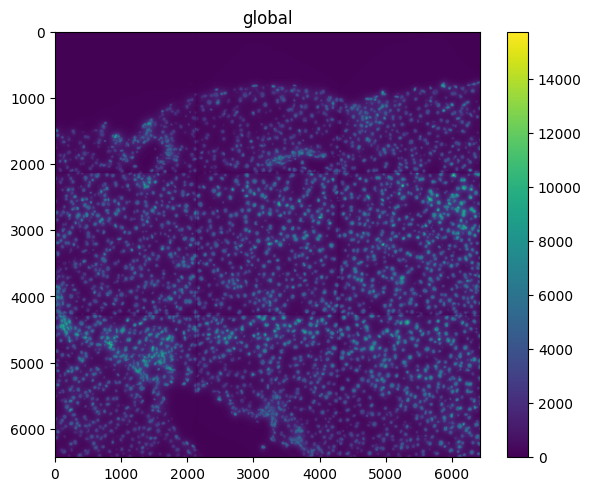

In [3]:
sdata.pl.render_images().pl.show()

## Segmentation mask (as `labels`)

INFO     Rasterizing image for faster rendering.                                                                   


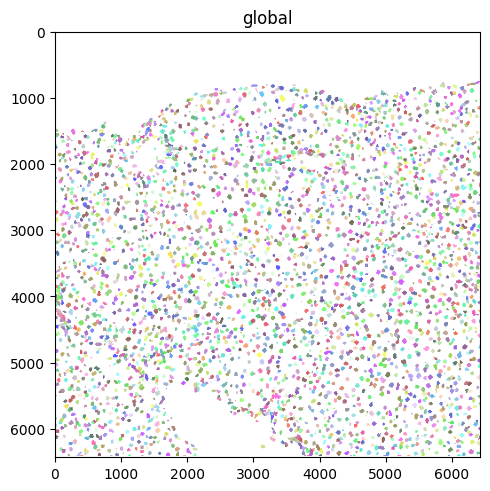

In [4]:
sdata.pl.render_labels().pl.show()

## Shapes (here, polygons)

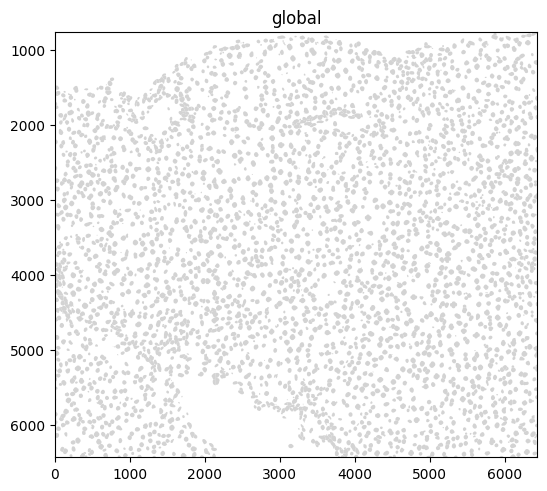

In [5]:
sdata.pl.render_shapes().pl.show()

We can either plot these separately or overlay them.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


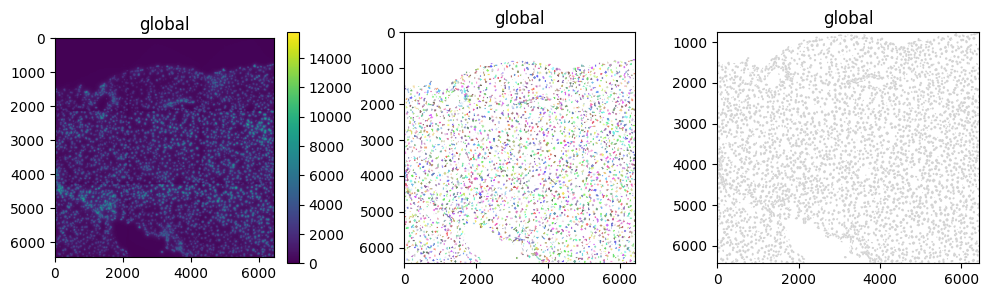

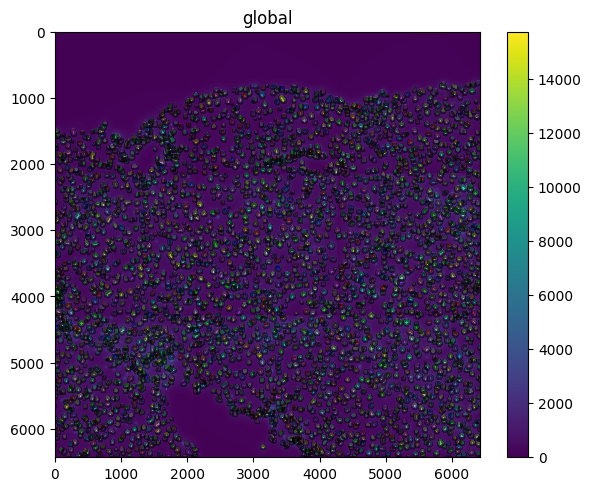

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

sdata.pl.render_images().pl.show(ax=axs[0])
sdata.pl.render_labels().pl.show(ax=axs[1])
sdata.pl.render_shapes().pl.show(ax=axs[2])

sdata.pl.render_images().pl.render_labels().pl.render_shapes(fill_alpha=0, outline_alpha=0.5).pl.show()

## Transformations and coordinate systems

In [7]:
sdata

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/mouse_liver/data.zarr
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 6432, 6432), (1, 1608, 1608)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (6432, 6432)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3375, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3375, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)

In the `repr` printed above, you can already see that the `SpatialData` object contains information on coordinate systems.

Specifically, each element can be aligned to one (or more) coordinate systems via a coordinate transformation (e.g. a translation or an affine transformation). See the figure.

<img src="attachments/coordinate_systems.png" alt="coordinate systems" style="max-width: 800px;">


Some details:
- with the current implementation coordinate transformations can only be specified between elements (left side of the figure) and coordinate systems (right side of the figure); they cannot be specified between elements, between coordinate systems, or between coordinate systems and elements.
- if the coordinates in the *intrinsic coordinate system of an element* (what is called "pixel" coordinate system above) are identical to the coordinates in the coordinate system the element is located, then the element will be mapped to that cooordinate system using an `Identity()` transformation.

Examples (shown in the figures below):
1. if you have one image and a set of points and the data is already aligned to each other (i.e. pixels and points coordinates corresponds without requiring transformations), then the configuration will be to have one coordinate system (the default name when it is not specified is called `global`, and two `Identity` transformations, each mapping one element to the common coordinate system.
2. if you have two sets of images and two sets of points, where the image 1 is alreaedy aligned to the points 1, and the image 2 is already aligned to the points 2, then a way to represent the data is to have two coordinate systems, for instance named `sample1` and `sample2`, and where all the 4 transformations are `Identity`.
3. finally suppose to have an image and points already aligned to the `sample1` coordinate system, as explained above, but now to have also a new image to align to sample 1 that is 2 times larger (in terms of pixels). We can align it using a `Scale` transformations.

Notes:
in the example aboves there were no rotations, nor translation (in particular the origin of all the images and points were identical); in the rest of the notebook we will examine more elaborate examples.

<img src="attachments/coordinate_transformations.png" alt="coordinate transformations" style="max-height: 800px;">

After this small theoretical introduction, let's go back to our code example. There are 3 elements aligned to the `global` coordinate system:

- `raw_image`: the raw DAPI image.
- `segmentation_mask`: the cell segmentation mask (raster data).
- `nucleus_boundaries`: the cell segmentation as polygons (vector data).

`global` is the default coordinate system that is added at the parsing stage, if no other transformation is specified. We can also expect that they are all {class}`spatialdata.transformations.Identity` transformations.
Let's print the availale coordinate systems in the SpatialData object and the transformations.

In [8]:
print(sdata.coordinate_systems)
print(
    get_transformation(sdata["raw_image"]),
    get_transformation(sdata["segmentation_mask"]),
    get_transformation(sdata["nucleus_boundaries"]),
)

['global']
Identity  Identity  Identity 


In [9]:
# note: the results of these two functions are identical because global is the default argument for `to_coordinate_system`
get_transformation(sdata.images["raw_image"]) == get_transformation(
    sdata.images["raw_image"], to_coordinate_system="global"
)

True

Now that we understood what a transformation and a coordinate system are, let's see how we can use them.

Let's start by creating a new transformation, a simple {class}`spatialdata.transformations.Scale`. This transformation will scale the `"y"` axis by a factor of 2.

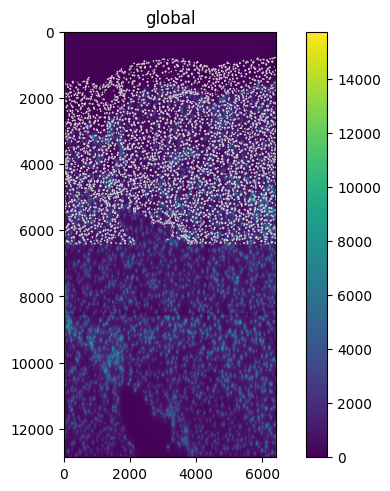

In [10]:
scale = Scale([2.0], axes=("y",))

set_transformation(sdata.images["raw_image"], scale, to_coordinate_system="global")

sdata.pl.render_images().pl.render_shapes().pl.show()

Note that our APIs allow us to apply and visualize transformations to raster and vector, with the same function call.

## Various transformations

Let's now explore various transformations available in `SpatialData`.

### MapAxis

The {class}`spatialdata.transformations.MapAxis` transformation can be used to permute the axis of the elements.

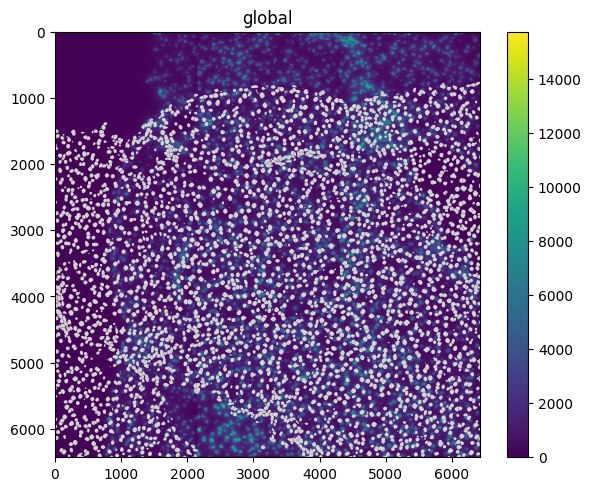

In [11]:
map_axis = MapAxis({"x": "y", "y": "x"})

set_transformation(sdata.images["raw_image"], map_axis, to_coordinate_system="global")

sdata.pl.render_images().pl.render_shapes().pl.show()

### Affine

The {class}`spatialdata.transformations.Affine` transformation can be used to apply an affine transformation to the elements. Let's start with a rotation of 30 degrees (i.e. $\pi / 6$ radians).

INFO     Rasterizing image for faster rendering.                                                                   


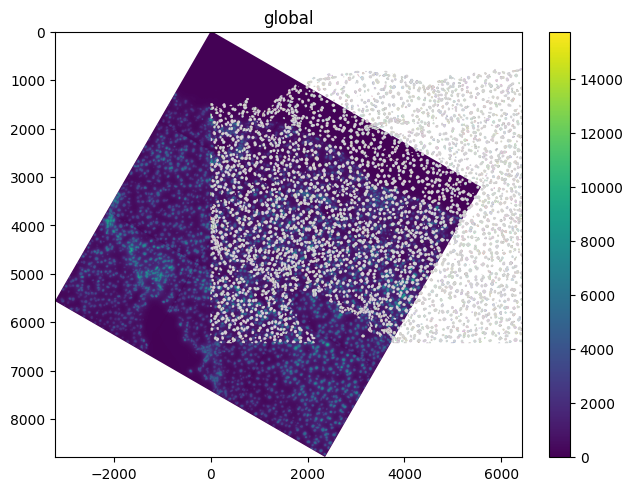

In [12]:
theta = math.pi / 6
rotation = Affine(
    [
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0, 1],
    ],
    input_axes=("x", "y"),
    output_axes=("x", "y"),
)

set_transformation(sdata.images["raw_image"], rotation, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

### Translation

The {class}`spatialdata.transformations.Translation` transformation can be used to apply a translation to the element.

INFO     Rasterizing image for faster rendering.                                                                   


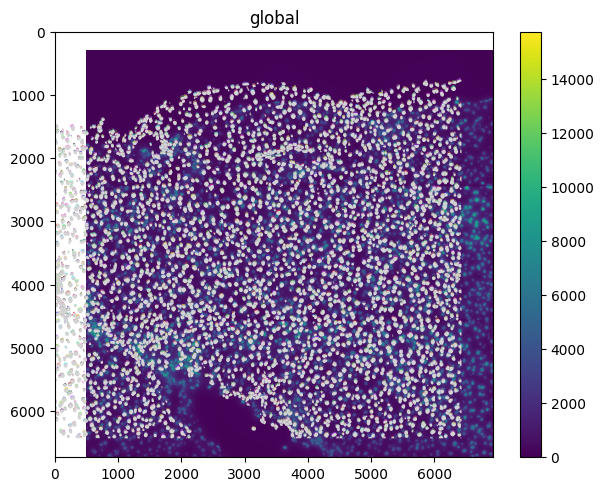

In [13]:
translation = Translation([500, 300], axes=("x", "y"))

set_transformation(sdata.images["raw_image"], translation, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

### Affine transformation and composition

The {class}`spatialdata.transformations.Sequence` transformation class can be used to compose transformations. This class allows to compose multiple transformations and it can be used even when the axes do not strictly match (for example here we are combining the affine rotation, defined for the `('x', 'y')` axes, with the scale, defined for the `('y')` axis).

INFO     Rasterizing image for faster rendering.                                                                   


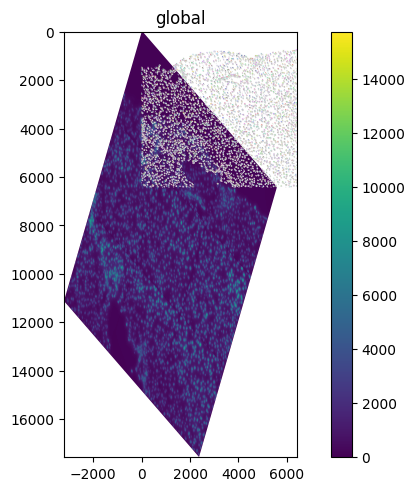

In [14]:
sequence = Sequence([rotation, scale])

set_transformation(sdata.images["raw_image"], sequence, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

We can also visualize the resulting affine matrix of the transformation.

In [15]:
print(sequence.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))

[[ 0.8660254  -0.5         0.        ]
 [ 1.          1.73205081  0.        ]
 [ 0.          0.          1.        ]]


As shown before, transformations can be applied to various elements without the constraint that the axes must match.
For example, a {class}`spatialdata.transformations.Scale` transformation over axis `"y"` can be applied both to shapes `('x', 'y')` and to images `('c', 'y', 'x')`.

In [16]:
sdata

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/mouse_liver/data.zarr
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 6432, 6432), (1, 1608, 1608)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (6432, 6432)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3375, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3375, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)

INFO     Rasterizing image for faster rendering.                                                                   


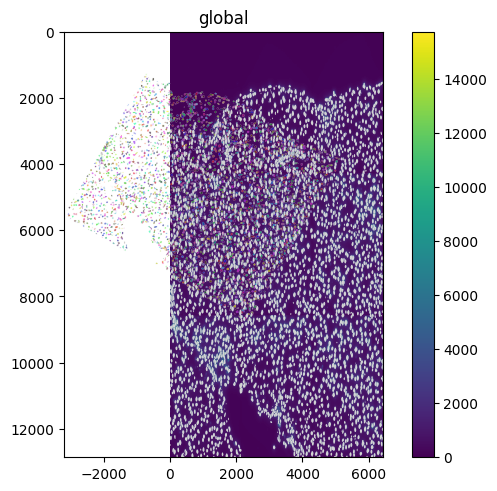

In [17]:
set_transformation(sdata["raw_image"], scale, to_coordinate_system="global")
set_transformation(sdata["nucleus_boundaries"], scale, to_coordinate_system="global")
set_transformation(sdata["segmentation_mask"], rotation, to_coordinate_system="global")

sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

### Inverse transformations

Most of the transformations also have an `inverse` method that returns the inverse transformation. If composed, they effectively cancel each other out.

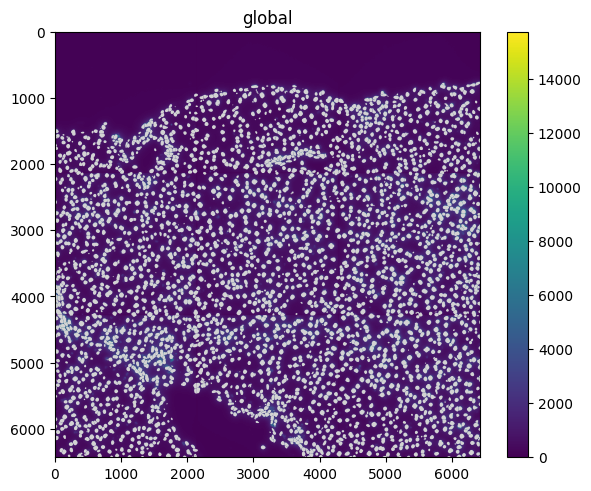

In [18]:
sequence = Sequence([rotation, rotation.inverse(), scale, scale.inverse()])

set_transformation(sdata["raw_image"], sequence, to_coordinate_system="global")
set_transformation(sdata["nucleus_boundaries"], sequence, to_coordinate_system="global")

# the image will result untransformed because the inverse transformations cancel each others
sdata.pl.render_images().pl.render_shapes().pl.show()

## Some details to keep in mind
Here are some important clarifications to make to avoid sources of confusion.

### Known bug: pixel-perfectedness
When using APIs such as `transform()`, `rasterize()` and `transform_to_data_extent()` (all shown below), we may get a [misalignment of half-pixel magnitude](https://github.com/scverse/spatialdata/issues/165). We identified the root of the problem and we will make a fix in one of the next releases.

### Coordinate transformations vs `transform()`

When adding/remove coordinate transformations as we showed above, we are not modifying the actual data, but just some lightweight metadata. For instance, if you add a rotation transformation to an image, the image data will not get rotated. If you want, you can call the {func}`spatialdata.transform()` function to actually create a new image object with the rotated data.

Generally, applying a transformation to raster data is not recommended, and it is instead preferred to:
- leave the data as it is, and let downstream methods handle the transformation. An example of this is in `spatialdata-plot` and `napari-spatialdata`; in these libraries we never call `transform()` and rather delegate the task of transforming the data to `matplotlib` and `napari`, by passing to them the raw data and the transformation metadata.
- transform (or inverse-transform) the vector data: vector data is lighter than raster data, so transforming it is generally preferred. An example of this is in the query APIs of `spatialdata`, where we want to crop an image based on an input region from a different coordinate system. To do so we do not transform the images to the query coordinate system, but rather we inverse-transform the query region to the image ("pixel") space, and perform the query on the raw untransformed image.

<img src="attachments/spatialdata_registration.png" alt="coordinate transformations vs transform()" style="max-height: 800px;">